In [40]:
#Для начала импортируем возможные библиотеки которые будем использовать при дальнейшей работе.
import pandas as pd
import os
import numpy as np
import datetime
import vk_api
import requests
import json
import random
import scipy.stats as ss

from statsmodels.stats.multicomp import (pairwise_tukeyhsd)
import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import plotly.express as px

import sys

from io import BytesIO
from datetime import timedelta
import requests
sns.set(style="whitegrid")

In [2]:
#Считываем файлы 
customer_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-kugotov/Папка с данными для проектов/olist_customers_dataset.csv")
orders_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-kugotov/Папка с данными для проектов/olist_orders_dataset.csv", parse_dates = True)
items_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-kugotov/Папка с данными для проектов/olist_order_items_dataset.csv")

In [4]:
customer_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [3]:
#Привели время к нормальому виду
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"])
orders_df["order_approved_at"] = pd.to_datetime(orders_df["order_approved_at"])
orders_df["order_delivered_carrier_date"] = pd.to_datetime(orders_df["order_delivered_carrier_date"])
orders_df["order_delivered_customer_date"] = pd.to_datetime(orders_df["order_delivered_customer_date"])
orders_df["order_estimated_delivery_date"] = pd.to_datetime(orders_df["order_estimated_delivery_date"])

items_df["shipping_limit_date"] = pd.to_datetime(items_df["shipping_limit_date"])

№1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

In [15]:
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [7]:
#Так как надо исказать пользователей, которые точно совершили покупку,
#то по моему мнению стоит оставить shipped и delivered, так как в этих случаях наш продукт точно оплатили

buy_df = orders_df.query("order_status == 'delivered' or order_status == 'shipped'")
buy_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [29]:
#Теперь объединяем нужные таблицы
buy_uniq_id = pd.merge(buy_df, customer_df, how = 'left', on = 'customer_id')
buy_uniq_id.shape()

(97585, 12)

In [33]:
buy_uniq_id \
    .groupby('customer_unique_id', as_index = False) \
    .count() \
    .query('order_id == 1') \
    .shape

(91538, 12)

Ответ: Клинтов ровно с одной покупкой 91538

№2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [36]:
#Если брать инофрмацию из информации по заказу orders_df,
#то по моему мнению надо брать типы заказов canceled
#unavailable не берем, так как информации по ним нет, может быть они были доставлены

causes_df = orders_df.query("order_status == 'canceled'")
causes_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17


In [38]:
#Посчитаем сколько всего было не доставлено 
causes_df.agg({'order_id' : 'count'})

order_id    625
dtype: int64

In [47]:
#Так как в данных у нас не один год, то 
causes_df.order_estimated_delivery_date.value_counts()

2018-03-12    9
2018-03-07    9
2018-03-09    9
2018-03-15    8
2017-12-01    7
             ..
2018-07-12    1
2017-10-11    1
2017-12-12    1
2017-09-05    1
2018-07-24    1
Name: order_estimated_delivery_date, Length: 289, dtype: int64

In [48]:
causes_df['month'] = causes_df["order_estimated_delivery_date"].apply(lambda x: x.strftime('%Y-%m'))
causes_df.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-02
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,2018-02
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,2018-09
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,2018-10


In [57]:
causes_df_month = causes_df \
    .groupby("month", as_index = False) \
    .agg({"customer_id" : "count"}) \
    .rename(columns = {'customer_id' : 'customer_id_count'})

causes_df_month.head()

,month,customer_id_count
0,2016-09,1
1,2016-10,3
2,2016-11,14
3,2016-12,8
4,2017-02,2


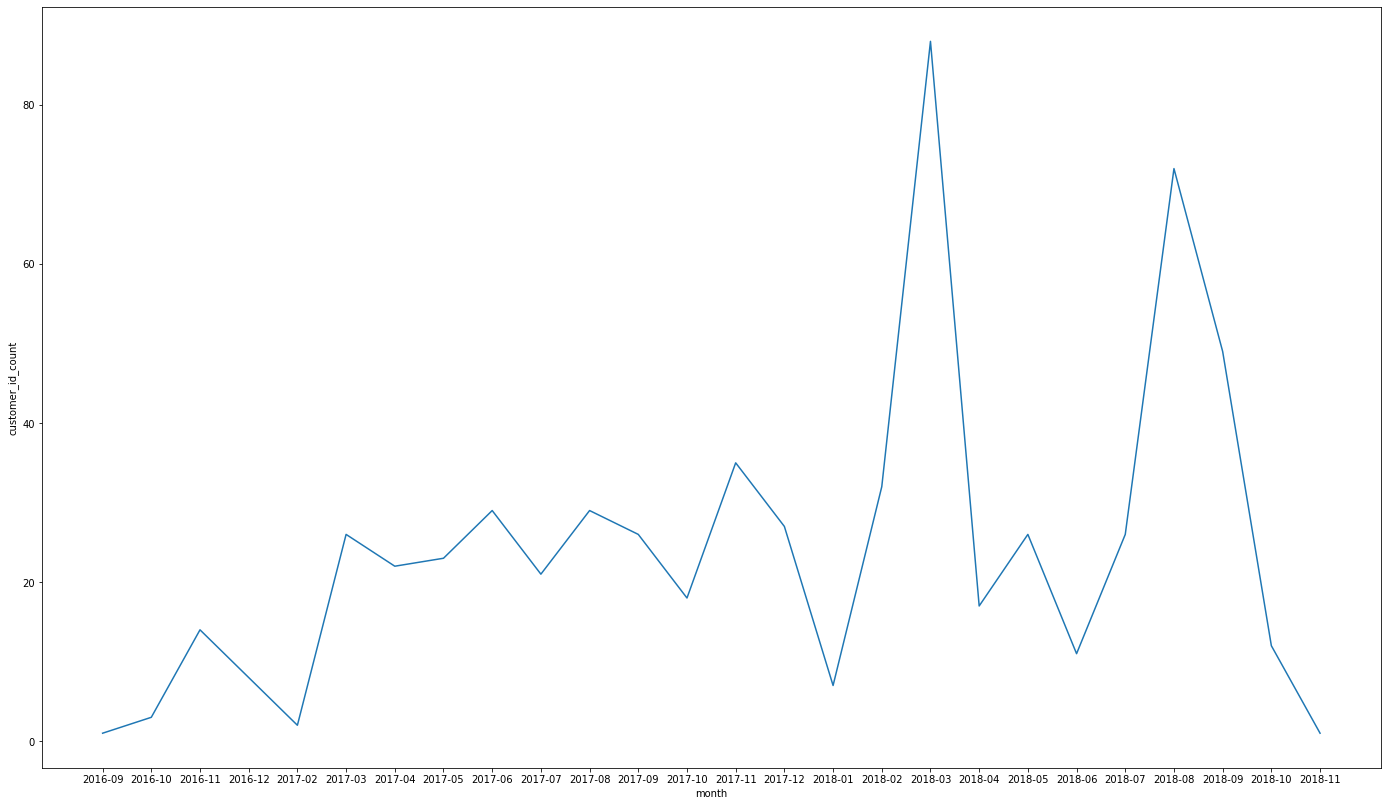

In [62]:
#Выведем рисунок по месяцам 

fig = plt.figure(figsize=(24,14))

sns.lineplot(data = causes_df_month, x = 'month', y = 'customer_id_count')

In [63]:
#Теперь посчитаем среднее по месяцам
causes_df_month.agg({'customer_id_count' : 'mean'})

customer_id_count    24.038462
dtype: float64

Ответ в среднем в месяц не доставляется 24.038462

№3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [8]:
#Для выполнения данной задачи надо взять данные из таблицы items (product_id) и объеденить их с данными из таблицы с данными о покупках.

orders = pd.merge(items_df, orders_df, how = "left", on = "order_id")
orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17


In [11]:
#Далее нужно определить день недели покупки каждого заказа 
orders["Day"] = orders["order_purchase_timestamp"].dt.day_name()
orders["Day"].value_counts()

Monday       18393
Tuesday      18237
Wednesday    17600
Thursday     16797
Friday       16039
Sunday       13416
Saturday     12168
Name: Day, dtype: int64

In [17]:
#Теперь групируем нашу таблицу по product_id и дню недели
items_day_count = orders \
    .groupby(["product_id", "Day"], as_index = False) \
    .agg({"order_id" : "count"}) \
    .rename(columns = {"order_id" : "count_per_week"})
items_day_count

,product_id,Day,count_per_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [19]:
#Выводим самый популярный день для покупки и количество самих покупок
items_day_count.groupby(["product_id"]).max().reset_index()

,product_id,Day,count_per_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Wednesday,1
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
...,...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Sunday,1
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
32948,fff9553ac224cec9d15d49f5a263411f,Friday,1
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


№4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

In [23]:
#Берем сделанный ранее датафрейм buy_df, где мы брали информацию об уже купленных товарах, и объединяем их с данными по покупателям

avg_buy_person = pd.merge(buy_df, customer_df, how = "left", on = "customer_id")
avg_buy_person.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [29]:
avg_buy_person_count = avg_buy_person \
    .groupby(["order_purchase_timestamp","customer_unique_id"], as_index = False) \
    .agg({"customer_id" : "count"}) \
    .rename(columns = {"customer_id" : "count_month"})

In [30]:
#далее нужно узнать сколько дней в месяце и разделить на неделю (7 дней)
avg_buy_person_count["count_weeks"] = avg_buy_person_count["order_purchase_timestamp"].dt.daysinmonth / 7
avg_buy_person_count.head()

,order_purchase_timestamp,customer_unique_id,count_month,count_weeks
0,2016-09-04 21:15:19,b7d76e111c89f7ebf14761390f0f7d17,1,4.285714
1,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,1,4.285714
2,2016-10-03 09:44:50,32ea3bdedab835c3aa6cb68ce66565ef,1,4.428571
3,2016-10-03 16:56:50,2f64e403852e6893ae37485d5fcacdaf,1,4.428571
4,2016-10-03 21:13:36,61db744d2f835035a5625b59350c6b63,1,4.428571


In [33]:
#Теперь выводим информацию по средним покупкам в неделю по месяцам
avg_buy_person_count["avg_per_week"] = avg_buy_person_count["count_month"] / avg_buy_person_count["count_weeks"]
avg_buy_person_count[["customer_unique_id", "avg_per_week"]]

,customer_unique_id,avg_per_week
0,b7d76e111c89f7ebf14761390f0f7d17,0.233333
1,830d5b7aaa3b6f1e9ad63703bec97d23,0.233333
2,32ea3bdedab835c3aa6cb68ce66565ef,0.225806
3,2f64e403852e6893ae37485d5fcacdaf,0.225806
4,61db744d2f835035a5625b59350c6b63,0.225806
...,...,...
97300,5c58de6fb80e93396e2f35642666b693,0.225806
97301,7febafa06d9d8f232a900a2937f04338,0.225806
97302,b701bebbdf478f5500348f03aff62121,0.225806
97303,24ac2b4327e25baf39f2119e4228976a,0.225806


№ 5.1. Выполните когортный анализ пользователей.

№ 5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из 10-го урока python, раздел “Стильный урок”, степ 5. (15 баллов)

Формируем когорты по совершению первой покупки. Когорты будем формировать по месяцам. Берем 2017 год, потому что по нему больше данных, чем по другим годам

In [20]:
#Дату покупки буду считать по столбцу order_approved_at
cohort = pd.merge(customer_df, orders_df, how = "left", on = "customer_id")
cohort.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [24]:
cohort['year_month'] = cohort['order_approved_at'].dt.strftime('%Y-%m')
cohort.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


In [36]:
cohort_2017 = cohort[(cohort['order_approved_at'].dt.year==2017)]
cohort_2017.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09


In [39]:
#Делим на когорты по первой покупке
cohort_df = cohort_2017.groupby('customer_unique_id', as_index=False) \
    .year_month.min() \
    .rename(columns = {"year_month" : "cohort_date"})
cohort_df.head()

,customer_unique_id,cohort_date
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07


In [40]:
f_cohort_df = pd.merge(cohort_2017, cohort_df, how = "left", on = "customer_unique_id")
f_cohort_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month,cohort_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09,2017-09
2,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11,2017-11
3,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11,2017-11
4,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09,2017-09


In [50]:
#Теперь группируем по дате начала когорты и дате покупки, считаем количество людей
cohort_finale = f_cohort_df \
    .groupby(["cohort_date", "year_month"], as_index = False) \
    .customer_unique_id.nunique() \
    .rename(columns = {"customer_unique_id" : "person_count"})

cohort_finale.head()

,cohort_date,year_month,person_count
0,2017-01,2017-01,727
1,2017-01,2017-02,4
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [51]:
#Считаем сколько покупали в месяц по количеству раз
count_person_month = cohort_2017.groupby("year_month", as_index = False) \
    .customer_unique_id.nunique() \
    .rename(columns = {"customer_unique_id" : "persons"})
count_person_month

,year_month,persons
0,2017-01,727
1,2017-02,1740
2,2017-03,2649
3,2017-04,2342
4,2017-05,3621
5,2017-06,3189
6,2017-07,3896
7,2017-08,4265
8,2017-09,4228
9,2017-10,4521


In [52]:
#теперь объединяем таблицы
cohort_analitics = pd.merge(cohort_finale, count_person_month, how = "left", on = "year_month")
cohort_analitics

,cohort_date,year_month,person_count,persons
0,2017-01,2017-01,727,727
1,2017-01,2017-02,4,1740
2,2017-01,2017-03,2,2649
3,2017-01,2017-04,1,2342
4,2017-01,2017-05,3,3621
...,...,...,...,...
72,2017-10,2017-11,30,7284
73,2017-10,2017-12,13,5760
74,2017-11,2017-11,7164,7284
75,2017-11,2017-12,39,5760


In [53]:
cohort_analitics["retention"] = cohort_analitics["person_count"] / cohort_analitics["persons"] * 100
cohort_analitics.head()

,cohort_date,year_month,person_count,persons,retention
0,2017-01,2017-01,727,727,100.000000
1,2017-01,2017-02,4,1740,0.229885
2,2017-01,2017-03,2,2649,0.075500
3,2017-01,2017-04,1,2342,0.042699
4,2017-01,2017-05,3,3621,0.082850


In [64]:
cohort_ff = cohort_analitics.pivot(index = "cohort_date", columns = "year_month", values = "retention")
cohort_ff

year_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_date,,,,,,,,,,,,
2017-01,100.0,0.229885,0.075500,0.042699,0.082850,0.031358,0.102669,0.023447,0.023652,NaN,0.027457,0.034722
2017-02,NaN,99.770115,0.151000,0.170794,0.082850,0.219505,0.051335,0.093787,0.070956,0.044238,0.054915,0.034722
2017-03,NaN,NaN,99.773499,0.555081,0.248550,0.282220,0.231006,0.093787,0.094607,0.176952,0.109830,0.052083
2017-04,NaN,NaN,NaN,99.231426,0.386634,0.156789,0.102669,0.164127,0.141911,0.176952,0.082372,0.138889
2017-05,NaN,NaN,NaN,NaN,99.199116,0.595798,0.462012,0.328253,0.260170,0.265428,0.205931,0.104167
2017-06,NaN,NaN,NaN,NaN,NaN,98.714331,0.385010,0.257913,0.307474,0.176952,0.151016,0.208333
2017-07,NaN,NaN,NaN,NaN,NaN,NaN,98.665298,0.468933,0.307474,0.176952,0.178473,0.121528
2017-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.569754,0.662252,0.331785,0.151016,0.277778
2017-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.131504,0.597213,0.274574,0.243056


In [74]:
#Приводим таблицу к подобающему виду

cohort_ff \
    .style \
    .set_caption('User retention by cohort') \
    .background_gradient(cmap='viridis') \
    .highlight_null('white') \


year_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_date,,,,,,,,,,,,
2017-01,100.000000,0.229885,0.075500,0.042699,0.082850,0.031358,0.102669,0.023447,0.023652,nan,0.027457,0.034722
2017-02,nan,99.770115,0.151000,0.170794,0.082850,0.219505,0.051335,0.093787,0.070956,0.044238,0.054915,0.034722
2017-03,nan,nan,99.773499,0.555081,0.248550,0.282220,0.231006,0.093787,0.094607,0.176952,0.109830,0.052083
2017-04,nan,nan,nan,99.231426,0.386634,0.156789,0.102669,0.164127,0.141911,0.176952,0.082372,0.138889
2017-05,nan,nan,nan,nan,99.199116,0.595798,0.462012,0.328253,0.260170,0.265428,0.205931,0.104167
2017-06,nan,nan,nan,nan,nan,98.714331,0.385010,0.257913,0.307474,0.176952,0.151016,0.208333
2017-07,nan,nan,nan,nan,nan,nan,98.665298,0.468933,0.307474,0.176952,0.178473,0.121528
2017-08,nan,nan,nan,nan,nan,nan,nan,98.569754,0.662252,0.331785,0.151016,0.277778
2017-09,nan,nan,nan,nan,nan,nan,nan,nan,98.131504,0.597213,0.274574,0.243056


Ответ: Можно увидеть на графике, что самый большой показатель retention на 3 месяц у 5 мясяца

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Создание RFM-метрик
Для каждого пользователя рассчитаем три метрики:
Recency (R) — время от последней покупки пользователя до текущей даты;
Frequency (F) — суммарное количество покупок у пользователя за всё время;
Monetary (M) — сумма покупок за всё время.

In [8]:
#Для начала объеденим все таблицы
full_df = pd.merge(buy_df, customer_df, how = "left", on = "customer_id")
full_df = pd.merge(full_df, items_df, how = "left", on = "order_id")
full_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [10]:
#найдем есть ли в столбце price нули
full_df.query('price.isnull()')
full_df = full_df.dropna(subset=['price'])
full_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [11]:
#теперь нам надо для рассчета R найти сегодняшнюю дату
today_date = full_df['order_purchase_timestamp'].max()
today_date

Timestamp('2018-09-03 09:06:57')

In [23]:
last_year = today_date - timedelta(days=365)
last_year = pd.to_datetime(last_year)

In [28]:
#так как мы будем изучать данные за последний год, надо их почистить 
fill_rfm = full_df[full_df['order_purchase_timestamp'] >= last_year]
fill_rfm

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111374,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2.0,49d2e2460386273b195e7e59b43587c3,1caf283236cd69af44cbc09a0a1e7d32,2017-10-10 20:07:14,26.90,36.98
111378,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
111380,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
111381,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [34]:
#теперь достолбец с количеством дней после завершенноей покупки
fill_rfm['last_day'] = (today_date - fill_rfm["order_purchase_timestamp"]).dt.days
fill_rfm

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,last_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,335
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,40
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,26
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,288
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111374,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2.0,49d2e2460386273b195e7e59b43587c3,1caf283236cd69af44cbc09a0a1e7d32,2017-10-10 20:07:14,26.90,36.98,333
111378,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,208
111380,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,237
111381,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,237


In [36]:
#Теперь делаем первую часть RFM таблицы
RFM = fill_rfm \
    .groupby("customer_unique_id", as_index = False) \
    .agg({"last_day": lambda x: x.min(), "customer_id" : "count", "price" : "sum"}) \
    .rename(columns = {"last_day" : "recency", "customer_id" : "frequency", "price" : "monetary"})

RFM

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,292,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,154.00
...,...,...,...,...
72717,fffb09418989a0dbff854a28163e47c6,259,1,58.00
72718,fffbf87b7a1a6fa8b03f081c5f51a201,249,1,149.00
72719,fffcc512b7dfecaffd80f13614af1d16,145,1,688.00
72720,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89


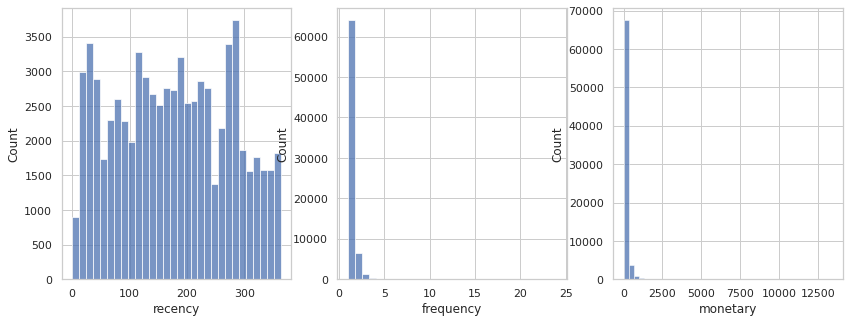

In [44]:
#Смотрим распределение, чтобы потом построить рамки

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.histplot(RFM['recency'], bins = 30)

plt.subplot(1, 3, 2)
sns.histplot(RFM['frequency'], bins = 30)

plt.subplot(1, 3, 3)
sns.histplot(RFM['monetary'], bins = 40)

In [46]:
# Задаем рамки используя квантили
quintiles = RFM[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 74.0, 0.4: 142.0, 0.6: 206.0, 0.8: 278.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.7}}

In [50]:
#Распределяем показатели по квантилям
#Чем больше Frequency и Monetry тем лучше. Чем меньше Recency тем лучше.

def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [52]:
RFM['R'] = RFM['recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['frequency'].apply(lambda x: fm_score(x, 'frequency'))
RFM['M'] = RFM['monetary'].apply(lambda x: fm_score(x, 'monetary'))
RFM

,customer_unique_id,recency,frequency,monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1,1,5
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,154.00,3,1,4
...,...,...,...,...,...,...,...
72717,fffb09418989a0dbff854a28163e47c6,259,1,58.00,2,1,2
72718,fffbf87b7a1a6fa8b03f081c5f51a201,249,1,149.00,2,1,4
72719,fffcc512b7dfecaffd80f13614af1d16,145,1,688.00,3,1,5
72720,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,2,1,2


In [54]:
RFM['RFM Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,411
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1,1,5,115
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,154.00,3,1,4,314


Я собираюсь работать с 11 сегментами, основываясь на баллах R и F.

**Лидеры** приобретенные недавно, покупают часто и тратят больше всего

**Постоянные клиенты** совершают покупки на регулярной основе. Реагируют на рекламные акции.

**Потенциальные клиенты** лоялисты совершают покупки в последнее время со средней частотой.

**Недавние клиенты** совершали покупки в последнее время, но не часто.

**Перспективные покупатели** в последнее время, но потратили немного.

**Клиенты, которые нуждаются во внимании** по новизне, частоте и денежным показателям, превышающим средний уровень. Возможно, они купили не так давно.

**Вот-вот перестанут покупать** по новизне и частоте. Потеряют их, если не возобновят.

**Риск** приобретать часто, но давно. Нужно вернуть их! 

**Их нельзя потерять**, они часто покупали, но не возвращались в течение длительного времени.

**Последняя покупка была в режиме ожидания**, и количество заказов было небольшим. Могут быть утеряны.

In [55]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,411,promising
2,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1,1,1,111,hibernating
3,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1,1,5,115,hibernating
4,0004bd2a26a76fe21f786e4fbd80607f,150,1,154.00,3,1,4,314,about to sleep


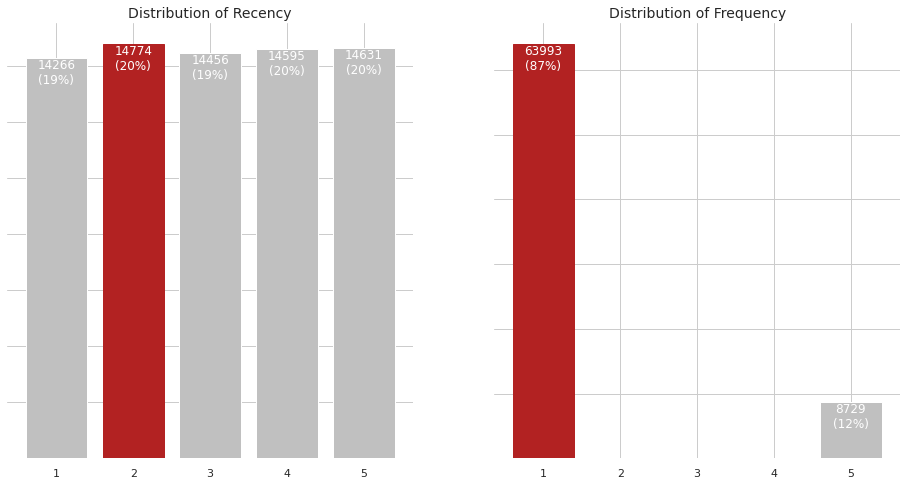

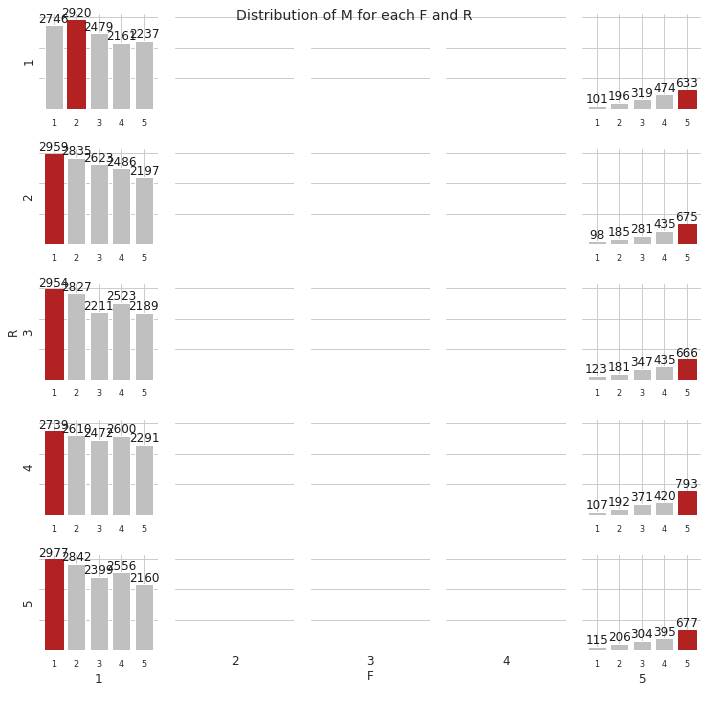

In [58]:
#Визуализируем
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = RFM[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = RFM[(RFM['R'] == r) & (RFM['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

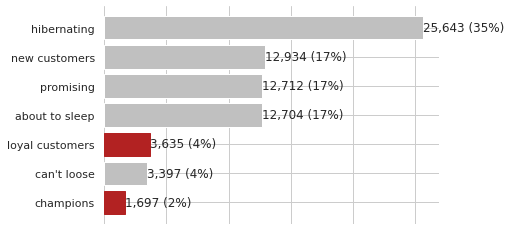

In [59]:
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

**Общий вывод во RFM оценке**.

Хочется сказать, что у нас очень большой процент покупателей занимают люди которые уже давно не совершали каких-либо действий 35%.

Если же говрить про лояльных покупателей, то в процентном соотношении их совсем мало, около 6%.

Также стоит отметить, что у нас давольно много новых покупателей и тех, кто много покупает по количесту но мало тратит денег, обоих по 17%

Есть еще покупатели, которые раньше много покупали, но по непонятным причинам давно этого не делали, их около 4%.